In [44]:
import pandas as pd
df = pd.read_csv('C:/Algo360/My python codes/ml.csv')
df_test=pd.read_csv('C:/Algo360/My python codes/Bankmessagetypetest.csv')
df_test['message'].str.lower()

0      rs. 1,100.00 credited from a/c xxxxxxxx411996 ...
1      an awesome personal loan offer for you!- rate ...
2      an awesome personal loan offer for you!- rate ...
3      dear pradeep, you are pre-qualified for variou...
4      dear pradeep, loan request received for inr 5,...
5      dear customer, hdfc bank personal loan loan ap...
6      dear pradeep, we have received your payment of...
7      rs. 2,200.00 credited from a/c xxxxxxxx411996 ...
8      dear pradeep, please email us the missing docu...
9      dear pradeep, get an online personal loan of u...
10     congratulations! rs.1000/- amazon voucher is u...
11     sbi credit card bill payment made online from ...
12     dear pradeep, get an online personal loan of u...
13     whetting wednesday! reapply for a cashe loan w...
14     /u0aaa/u0acd/u0ab0/u0abf/u0aaf /u0aae/u0aa3/u0...
15     /u0a95/u0ac7/u0aaa/u0abf/u0a9f/u0ab2 /u0aab/u0...
16     dear customer, if you are in to any business a...
17     you have just logged in 

In [46]:
df = df[pd.notnull(df['message'])]
df_test = df_test[pd.notnull(df_test['message'])]
df['message']=df['message'].str.lower()
df_test['message']=df_test['message'].str.lower()

In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 1 columns):
message    500 non-null object
dtypes: object(1)
memory usage: 7.8+ KB


In [24]:
df_test.columns

Index([u'message'], dtype='object')

In [25]:
df['category_id'] = df['messagetype'].factorize()[0]
from io import StringIO
category_id_df = df[['messagetype', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'messagetype']].values)

In [26]:
id_to_category

{0L: 'Debit',
 1L: 'Credit',
 2L: 'Advert',
 3L: 'Balance',
 4L: 'Declined_due_to_insufficint_fund',
 5L: 'Declined_due_to_other',
 6L: 'EmiDue_Reminder',
 7L: 'Info',
 8L: 'OTP',
 9L: 'Payment_due',
 10L: 'Declined_due_to_others'}

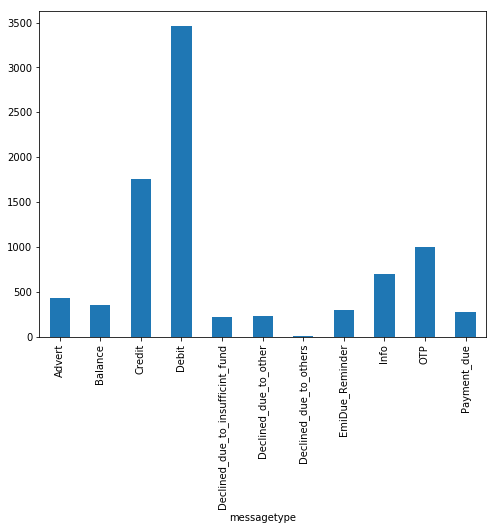

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline 
fig = plt.figure(figsize=(8,6))
df.groupby('messagetype').message.count().plot.bar(ylim=0)
plt.show()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.message).toarray()
labels = df.category_id


In [29]:
features.shape

(8708L, 6793L)

In [30]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for messagetype, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(messagetype))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Advert':
  . Most correlated unigrams:
       . happy
       . apply
  . Most correlated bigrams:
       . wishes happy
       . happy birthday
# 'Balance':
  . Most correlated unigrams:
       . eod
       . ledger
  . Most correlated bigrams:
       . 00 dr
       . ledger balance
# 'Credit':
  . Most correlated unigrams:
       . deposit
       . credited
  . Most correlated bigrams:
       . credited inr
       . credited rs
# 'Debit':
  . Most correlated unigrams:
       . otp
       . debited
  . Most correlated bigrams:
       . debited inr
       . debited rs
# 'Declined_due_to_insufficint_fund':
  . Most correlated unigrams:
       . funds
       . insufficient
  . Most correlated bigrams:
       . insufficient funds
       . declined insufficient
# 'Declined_due_to_other':
  . Most correlated unigrams:
       . declined
       . incorrect
  . Most correlated bigrams:
       . incorrect pin
       . declined incorrect
# 'Declined_due_to_others':
  . Most correlated unigrams

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(df['message'], df['messagetype'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [32]:
X_test_counts = count_vect.fit_transform(df_test['message'])
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
features_test = tfidf.transform(df_test.message).toarray()

In [33]:
features_test.shape

(500L, 6793L)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\users\shikha~1\desktop\virtua~1\algo_b~1\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


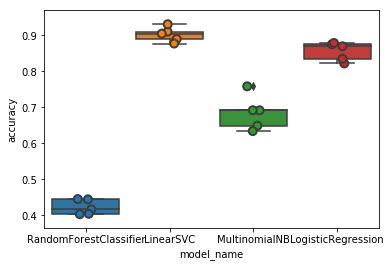

In [35]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [36]:

cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.902844
LogisticRegression        0.856350
MultinomialNB             0.685345
RandomForestClassifier    0.423031
Name: accuracy, dtype: float64

In [37]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [38]:
Predicted = model.predict(features_test)
score = metrics.accuracy_score(y_test, Predicted)
print(score)


In [20]:
Predicted_df = pd.DataFrame({'Column1':Predicted[:,]})
df_test['messagetype']=Predicted_df
Predicted_df['Column1'].value_counts()
testfile=df_test.to_csv('C:/Algo360/My python codes/BankmessagetypetestOutput.csv',sep=',')

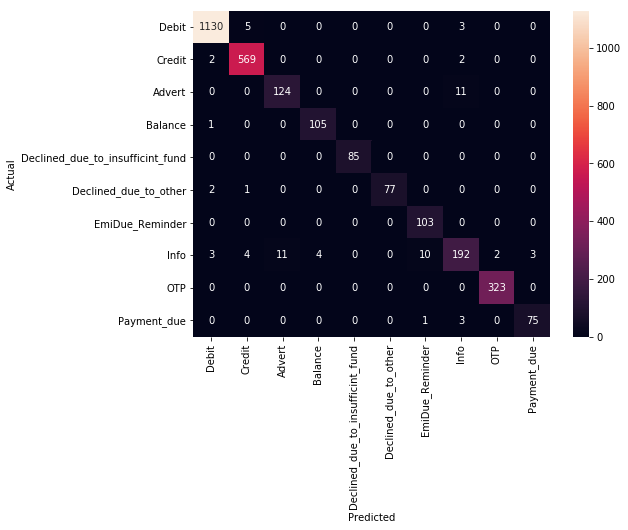

In [26]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.messagetype.values, yticklabels=category_id_df.messagetype.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['messagetype', 'message']])
      print('')

'Info' predicted as 'Advert' : 11 examples.


,messagetype,message
7040,Info,THANK YOU FOR USING UNITED BANK RUPAY PLATINUM...
7334,Info,"DEAR CUST, PL PAY YOUR VEH LOAN OVERDUE (IF AN..."
6776,Info,"AS PER RBI GUIDELINES, YOU CAN DO FREE MONEY T..."
7226,Info,ALERT! RS3 (13 PTS)WILL LAPSE FROM YOUR SBI RE...
7312,Info,DEAR APPLICANT YOUR HDFC BANK CREDIT CARD APP ...
7313,Info,"DEAR APPLICANT, YOUR ICICI BANK PERSONAL LOAN ..."
6777,Info,"AXIS BANK EDGE REWARDS: DEAR CUSTOMER, WE URGE..."
6900,Info,"DEAR CUSTOMER, YOU HAVE UTILIZED MORE THAN 75%..."
6809,Info,"DEAR CUSTOMER, THANK YOU FOR USING ICICI BANK ..."
6813,Info,DEAR CUSTOMER CASH WITHDRAWAL LIMIT ON YOUR CR...



'Info' predicted as 'EmiDue_Reminder' : 10 examples.


,messagetype,message
6847,Info,EMI DUE ON14062018 IN A/C XXXXX423788. PLEASE ...
7333,Info,"DEAR CUST, ECS FOR HDFC BANK TWO WHEELER LOAN#..."
6851,Info,EMI DUE ON14082018 IN A/C XXXXX423788. PLEASE ...
6883,Info,GREETINGS FROM SHUBH LOANS! YOUR EMI IS DUE ON...
6864,Info,EMI DUE ON31072018 IN A/C XXXXX881940. PLEASE ...
6861,Info,EMI DUE ON31072018 IN A/C XXXXX115024. PLEASE ...
6841,Info,EMI DUE ON14042018 IN A/C XXXXX423788. PLEASE ...
6856,Info,EMI DUE ON20062018 IN A/C XXXXX260761. PLEASE ...
6853,Info,EMI DUE ON20042018 IN A/C XXXXX260761. PLEASE ...
6849,Info,EMI DUE ON14072018 IN A/C XXXXX423788. PLEASE ...



'Advert' predicted as 'Info' : 11 examples.


,messagetype,message
5256,Advert,DON'T WANT TO KEEP MINIMUM BALANCE IN YOUR ACC...
5303,Advert,250 PAPERLESS MUTUAL FUNDS ARE WAITING FOR YOU...
5541,Advert,DUE TO CHANGE IN BANK'S UPI TRANSACTION APPROV...
5379,Advert,"BEWARE OF CALLS FROM TELECOM OPERATOR, ASKING ..."
5378,Advert,"BEWARE OF CALLS FROM TELECOM OPERATOR, ASKING ..."
5428,Advert,"DEAR BAJAJ CUSTOMER, YOUR CIBIL SCORE MAY CHAN..."
5248,Advert,CONGRATULATIONS! YOUR IPIN HAS BEEN SUCCESSFUL...
5315,Advert,ACHIEVE YOUR FREEDOM FROM MEDICAL EXPENSES WIT...
5475,Advert,"DEAR CARDMEMBER, DOWNLOAD RBL MY CARD MOBILE A..."
5523,Advert,"DEAR CUSTOMER, THANK YOU FOR YOUR PATRONAGE. F..."


In [28]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [31]:
from sklearn.feature_selection import chi2

N = 2
for messagetype, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(messagetype))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Advert':
  . Top unigrams:
       . apply
       . free
  . Top bigrams:
       . customer avail
       . sbi credit
# 'Balance':
  . Top unigrams:
       . balance
       . balances
  . Top bigrams:
       . balance account
       . crdownload yono
# 'Credit':
  . Top unigrams:
       . credited
       . received
  . Top bigrams:
       . credited rs
       . credited inr
# 'Debit':
  . Top unigrams:
       . debited
       . withdrawn
  . Top bigrams:
       . debited rs
       . debited inr
# 'Declined_due_to_insufficint_fund':
  . Top unigrams:
       . insufficient
       . funds
  . Top bigrams:
       . insufficient funds
       . insufficient balance
# 'Declined_due_to_other':
  . Top unigrams:
       . declined
       . dishonoured
  . Top bigrams:
       . returned unpaid
       . 18 declined
# 'EmiDue_Reminder':
  . Top unigrams:
       . emi
       . ur
  . Top bigrams:
       . emi rs
       . customer emi
# 'Info':
  . Top unigrams:
       . added
       . changed
  . 